## Name : Jay Krish Vijendra
## Admin Number : 222197Y
<br>

# UberEats Analysis

# Introduction
The project aims to develop a text classification model for Uber Eats reviews, enhancing customer satisfaction by categorizing sentiments as positive, negative, or neutral. With a surge in low ratings threatening its reputation, Uber Eats seeks strategic improvements to address issues with app functionality, food quality, and service standards. By systematically analyzing Reviews, the proposed model offers vital insights into customer sentiments, enabling targeted enhancements to maintain competitiveness amidst fierce industry rivalry with Deliveroo and Grab.



# Dataset
The project leverages multiple datasets, including Google Playstore, Consumer Affairs, Trust Pilot, Product Review, and Sitejabber. These diverse sources provide a comprehensive range of customer feedback on Uber Eats, offering insights into various aspects of user experience and satisfaction. By aggregating data from these platforms, the text classification model gains a robust understanding of customer sentiments, facilitating targeted improvements to enhance service quality.


<a id='table_of_contents'></a>

1. [Import libraries](#imports)
2. [Import data](#import_data)
3. [Data exploration](#data_exploration)
4. [Data cleaning and preparation](#data_cleaning)
5. [Model training](#model_training)<br>
6. [Tuning](#tuning)<br>
7. [Validation](#validation)<br>

# 1. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import ast
from dateutil import parser
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.utils import to_categorical
from keras.utils import to_categorical


import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 2. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [2]:
df = pd.read_csv('cleaned_data.csv')
df

,stars,cleaned_text,sentiment
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive
...,...,...,...
8892,5,"['food', 'good', 'delivery', 'took', 'forever'...",positive
8893,1,"['whenever', 'never', 'sent', 'correct', 'item...",negative
8894,1,"['delivery', 'driver', 'turn', 'incorrect', 'l...",negative
8895,5,"['great', 'deal', 'buddy', 'pizza', 'buy', 'on...",positive


# 3. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

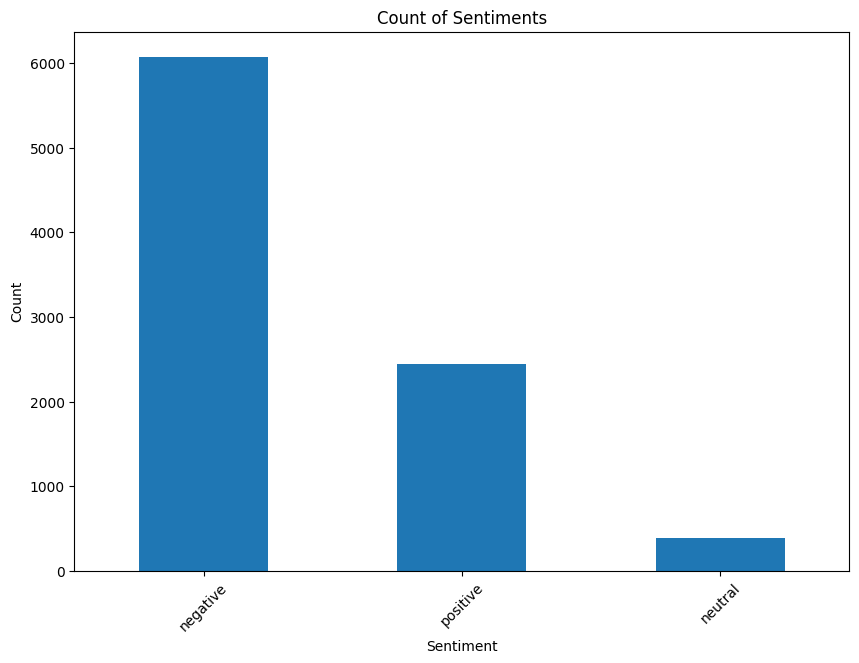

In [3]:
# Count the number of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plot bar chart
sentiment_counts.plot(kind='bar', figsize=(10,7))

plt.title('Count of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

From the chart, we can observe that there is a significant class imbalance among the sentiment categories. Specifically, it appears that one or more sentiment categories have notably higher counts compared to others. This imbalance is often problematic in machine learning tasks because it can lead to biased model performance, where the model may be more inclined to predict the majority class and overlook the minority classes.

In this case, it seems that the sentiment categories are skewed towards the negative sentiment. This imbalance suggests that the dataset may not adequately represent the true distribution of sentiments in the target population, potentially leading to biased model predictions.

To address this issue and mitigate bias, techniques such as oversampling and undersampling can be employed. Oversampling involves increasing the number of instances in the minority class, while undersampling involves reducing the number of instances in the majority class. By rebalancing the dataset in this manner, we can ensure that the model is exposed to a more equitable distribution of sentiments, thereby improving its ability to generalize and make accurate predictions across all sentiment categories.

# 4. Data cleaning and preparation <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [4]:
#  convert string representations of lists in 'cleaned_text' back to actual lists
df['cleaned_text_list'] = df['cleaned_text'].apply(ast.literal_eval)

# convert lists in 'cleaned_text_list' to strings
df['cleaned_text_str'] = df['cleaned_text_list'].apply(' '.join)

df.head()

,stars,cleaned_text,sentiment,cleaned_text_list,cleaned_text_str
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative,"[lately, common, wait, hour, food, passed, dri...",lately common wait hour food passed driver one...
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive,"[love, great, offer, good, selection, food, sh...",love great offer good selection food shopping ...
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative,"[disappointed, app, used, long, time, service,...",disappointed app used long time service fee ke...
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative,"[fairly, easy, use, trying, find, happening, c...",fairly easy use trying find happening contacti...
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive,"[like, fact, u, ca, get, refund, unless, u, ta...",like fact u ca get refund unless u take pictur...


In [5]:
# initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

In [6]:
# convert 'cleaned_text_str' into TF-IDF vectors
X = vectorizer.fit_transform(df['cleaned_text_str'])

# use 'sentiment' as target
y = df['sentiment']

Term Frequency-Inverse Document Frequency [TF-IDF], is a technique that assigns numerical values to words based on their importance in a document relative to a corpus. This method is highly effective in capturing the essence of textual data while mitigating the influence of common, less informative words (e.g., "the," "and"). By generating a TF-IDF matrix from the 'cleaned_text_str' column, the intricate nuances of the text are preserved in a structured numerical format. 

In [7]:
# Define oversampling strategy
over = RandomOverSampler(sampling_strategy='auto')

# Fit and apply the transform
X_over, y_over = over.fit_resample(X, y)

# Define undersampling strategy
under = RandomUnderSampler(sampling_strategy='auto')

# Fit and apply the transform
X_under, y_under = under.fit_resample(X, y)

Given the observed class imbalance in sentiment categories, oversampling and undersampling techniques were employed to address this issue. For oversampling, the RandomOverSampler class with a specified sampling strategy ('auto') was utilized to adjust the number of instances in each class, thus balancing the dataset. Similarly, the RandomUnderSampler class, also with a sampling strategy of 'auto', was employed for undersampling to reduce instances in the majority class, achieving dataset balance.

The resampling strategies were applied to the TF-IDF matrix (X) and the corresponding target variable (y), resulting in two sets of resampled datasets: X_over, y_over (for oversampling) and X_under, y_under (for undersampling). These steps collectively ensured that the text data was appropriately formatted, addressing class imbalance concerns and preparing it for subsequent machine learning modeling tasks.

# 5. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

In [8]:
# split the oversampled data into training and test sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [9]:
# split the undersampled data into training and test sets
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

## Logistic Regression

In [10]:
# initialize and train the Logistic Regression model on the oversampled data
lr_model_over = LogisticRegression()
lr_model_over.fit(X_train_over, y_train_over)

# make predictions on the test set
y_pred_over = lr_model_over.predict(X_test_over)

# print classification report for the oversampled data
print("Logistic Regression Metrics for Oversampled Data:")
print(classification_report(y_test_over, y_pred_over))

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_over, y_pred_over))

# print precision
print("\nPrecision: ", precision_score(y_test_over, y_pred_over, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_over, y_pred_over, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_over, y_pred_over, average='weighted'))

Logistic Regression Metrics for Oversampled Data:
              precision    recall  f1-score   support

    negative       0.96      0.90      0.93      1209
     neutral       0.92      1.00      0.96      1238
    positive       0.96      0.93      0.95      1194

    accuracy                           0.95      3641
   macro avg       0.95      0.95      0.95      3641
weighted avg       0.95      0.95      0.95      3641


Accuracy:  0.9458939851689097

Precision:  0.9472440353804125

Recall:  0.9458939851689097

F1 Score:  0.945587466774942


The logistic regression model trained on oversampled data exhibited strong performance in sentiment classification. Precision, recall, and F1-scores for each sentiment category (negative, neutral, and positive) were consistently high, ranging from 0.92 to 0.96. The model achieved an accuracy of 94.59%, indicating its ability to correctly classify sentiment labels. These results suggest that oversampling effectively addressed class imbalance issues, allowing the model to learn from the data and make accurate predictions. Additionally, the inherent characteristics of logistic regression likely contributed to its success in capturing underlying patterns in the text data. Overall, these findings highlight the efficacy of logistic regression for sentiment analysis tasks when combined with appropriate preprocessing techniques.

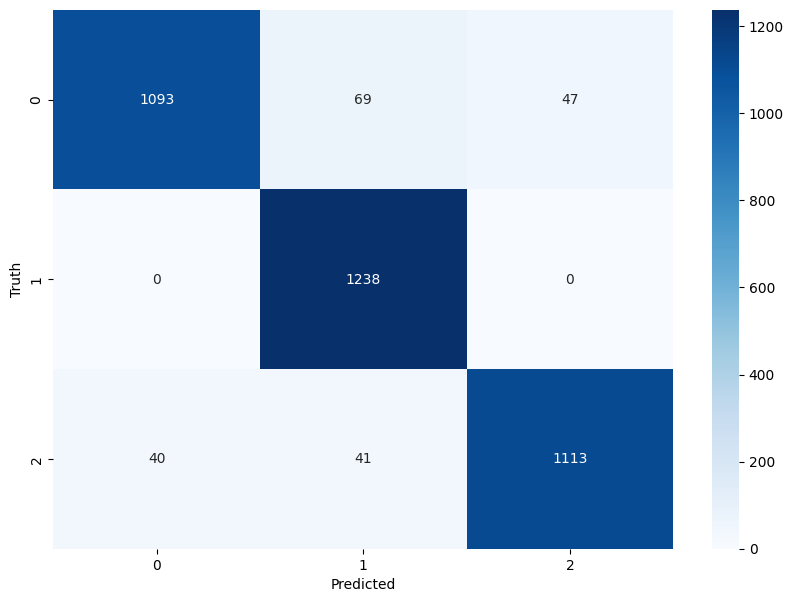

In [11]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [12]:
# initialize and train the Logistic Regression model on the undersampled data
lr_model_under = LogisticRegression()
lr_model_under.fit(X_train_under, y_train_under)

# make predictions on the test set
y_pred_under = lr_model_under.predict(X_test_under)

# print classification report for the undersampled data
print("\nLogistic Regression Metrics for Undersampled Data:")
print(classification_report(y_test_under, y_pred_under))


Logistic Regression Metrics for Undersampled Data:
              precision    recall  f1-score   support

    negative       0.79      0.74      0.77        84
     neutral       0.56      0.62      0.59        77
    positive       0.76      0.74      0.75        73

    accuracy                           0.70       234
   macro avg       0.71      0.70      0.70       234
weighted avg       0.71      0.70      0.70       234



In [13]:
# make predictions on the test set for undersampled data
y_pred_under = lr_model_under.predict(X_test_under)

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_under, y_pred_under))

# print precision
print("\nPrecision: ", precision_score(y_test_under, y_pred_under, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_under, y_pred_under, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_under, y_pred_under, average='weighted'))


Accuracy:  0.7008547008547008

Precision:  0.7084303866280794

Recall:  0.7008547008547008

F1 Score:  0.7037432731877177


The logistic regression model trained on the undersampled data exhibited inferior performance compared to its oversampled counterpart. With lower precision, recall, and F1-scores across all sentiment categories (negative, neutral, and positive), the model struggled to accurately classify sentiment labels. The accuracy was notably lower at 70.08%, indicating difficulty in discerning sentiment due to the reduced amount of representative data. 

This limitation stems from undersampling, which diminishes the training dataset by discarding instances from the majority class to address class imbalance. Consequently, the model's ability to capture underlying patterns in the data was compromised, resulting in suboptimal performance in sentiment classification tasks. Overall, while undersampling may mitigate class imbalance, it often leads to reduced data availability, negatively impacting model effectiveness in sentiment analysis.







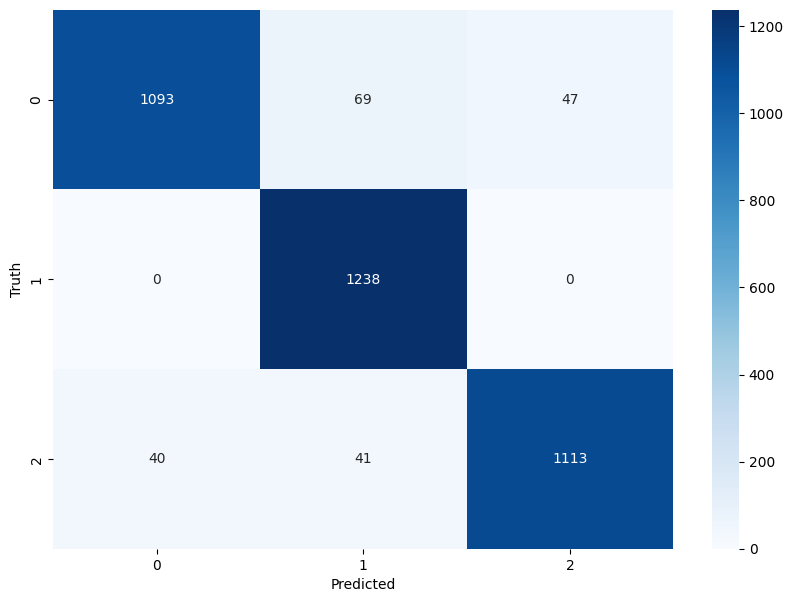

In [14]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Here are some possible reasons why the above has happend:

Loss of Information: Undersampling involves discarding instances from the majority class, potentially eliminating valuable information crucial for accurate classification. The removed instances may contain important patterns or nuances necessary for the model to generalize effectively to new data.

Overfitting: In cases where the minority class is significantly smaller than the majority class, undersampling can exacerbate overfitting. The model trained on the reduced dataset may become overly specialized to the limited data, failing to generalize well to unseen instances and leading to poor performance in real-world scenarios.

Representation Issues: Undersampling may result in a dataset that inadequately represents the majority class, particularly if the class exhibits diversity or variability. As a consequence, the model may struggle to capture the full spectrum of characteristics within the majority class, compromising its ability to accurately classify instances belonging to that class.

Reference: [Medium](https://priyanka-ddit.medium.com/how-to-deal-with-imbalanced-dataset-86de86c49)

# Naives Bayes Models
### Gaussian Naive Bayes Model

In [15]:
# initialize and train the Gaussian Naive Bayes model on the oversampled data
nb_model_over = GaussianNB()
nb_model_over.fit(X_train_over.toarray(), y_train_over)

GaussianNB()

In [16]:
# make predictions on the test set
y_pred_over = nb_model_over.predict(X_test_over.toarray())

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_over, y_pred_over))

# print precision
print("\nPrecision: ", precision_score(y_test_over, y_pred_over, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_over, y_pred_over, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_over, y_pred_over, average='weighted'))

# print classification report for the oversampled data
print("Gaussian Naive Bayes Model Metrics for Oversampled Data:")
print(classification_report(y_test_over, y_pred_over))


Accuracy:  0.7822026915682505

Precision:  0.8118918537028957

Recall:  0.7822026915682505

F1 Score:  0.7776440819644457
Gaussian Naive Bayes Model Metrics for Oversampled Data:
              precision    recall  f1-score   support

    negative       0.95      0.74      0.83      1209
     neutral       0.68      1.00      0.81      1238
    positive       0.80      0.60      0.69      1194

    accuracy                           0.78      3641
   macro avg       0.81      0.78      0.78      3641
weighted avg       0.81      0.78      0.78      3641



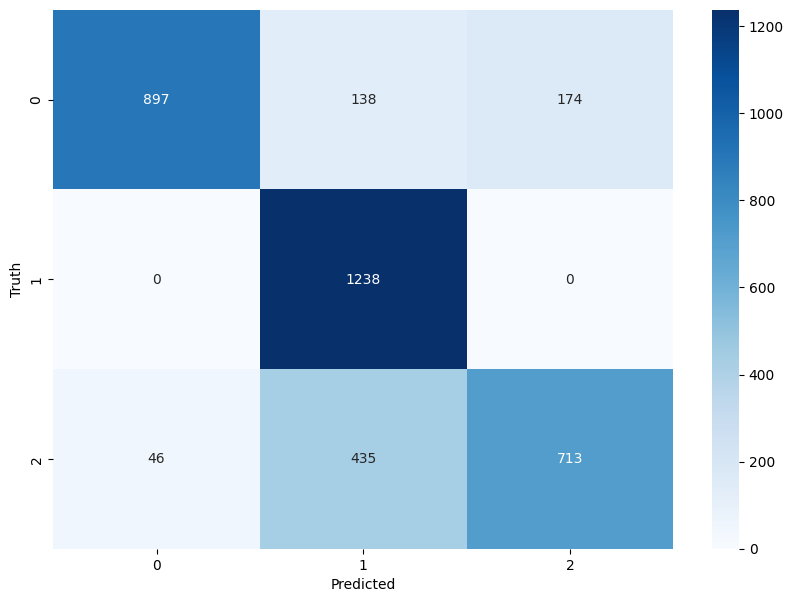

In [17]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Multinomial Naive Bayes Model

In [18]:
# initialize and train the Multinomial Naive Bayes model on the oversampled data
mnb_model_over = MultinomialNB()
mnb_model_over.fit(X_train_over, y_train_over)

MultinomialNB()

In [19]:
# make predictions on the test set
y_pred_over = mnb_model_over.predict(X_test_over)

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_over, y_pred_over))

# print precision
print("\nPrecision: ", precision_score(y_test_over, y_pred_over, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_over, y_pred_over, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_over, y_pred_over, average='weighted'))

print("Multinomial Naive Bayes Model Metrics for Oversampled Data:")
print(classification_report(y_test_over, y_pred_over))


Accuracy:  0.893435869266685

Precision:  0.8988025054215338

Recall:  0.893435869266685

F1 Score:  0.893623832245397
Multinomial Naive Bayes Model Metrics for Oversampled Data:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      1209
     neutral       0.84      0.95      0.89      1238
    positive       0.96      0.85      0.90      1194

    accuracy                           0.89      3641
   macro avg       0.90      0.89      0.89      3641
weighted avg       0.90      0.89      0.89      3641



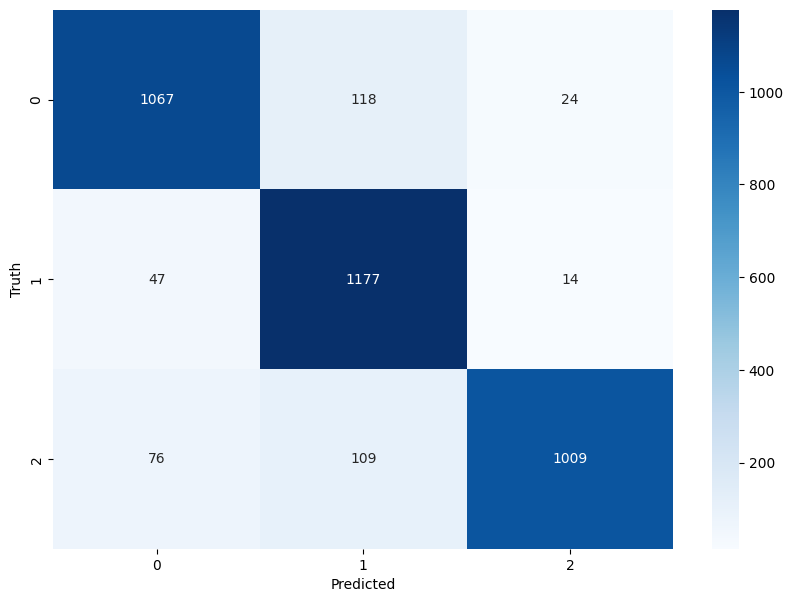

In [20]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Bernoulli Naive Bayes Model

In [21]:
# initialize and train the Bernoulli Naive Bayes model on the oversampled data
bnb_model_over = BernoulliNB()
bnb_model_over.fit(X_train_over, y_train_over)

BernoulliNB()

In [22]:
# make predictions on the test set
y_pred_over = bnb_model_over.predict(X_test_over)

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_over, y_pred_over))

# print precision
print("\nPrecision: ", precision_score(y_test_over, y_pred_over, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_over, y_pred_over, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_over, y_pred_over, average='weighted'))

print("Bernoulli Naive Bayes Model Metrics for Oversampled Data:")
print(classification_report(y_test_over, y_pred_over))


Accuracy:  0.8264213128261466

Precision:  0.8364596027954185

Recall:  0.8264213128261466

F1 Score:  0.8267156313131019
Bernoulli Naive Bayes Model Metrics for Oversampled Data:
              precision    recall  f1-score   support

    negative       0.91      0.77      0.83      1209
     neutral       0.84      0.80      0.82      1238
    positive       0.75      0.91      0.82      1194

    accuracy                           0.83      3641
   macro avg       0.84      0.83      0.83      3641
weighted avg       0.84      0.83      0.83      3641



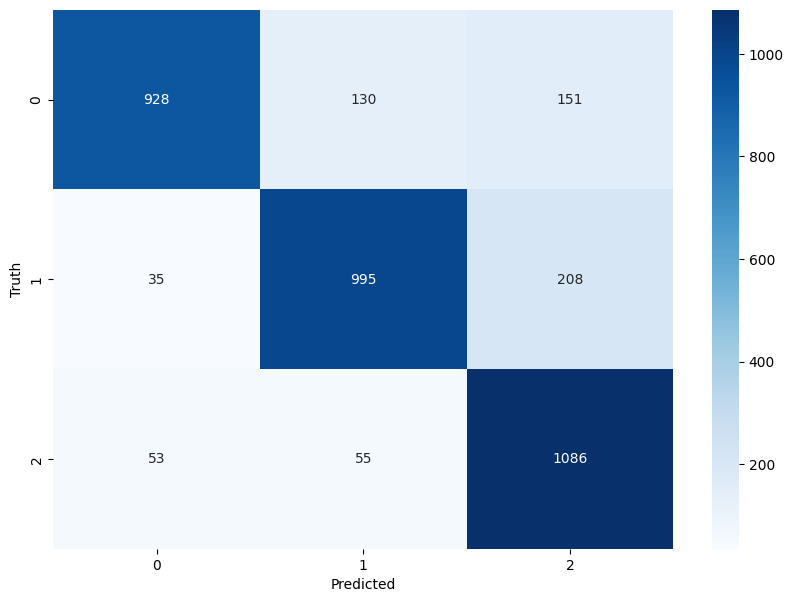

In [23]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

The Gaussian Naive Bayes, Multinomial Naive Bayes, and Bernoulli Naive Bayes models were employed for sentiment analysis on oversampled data. While Multinomial Naive Bayes exhibited the highest accuracy (89.34%) and balanced performance across precision, recall, and F1-score metrics, Gaussian Naive Bayes and Bernoulli Naive Bayes displayed lower accuracy (78.22% and 82.64%, respectively) and varying degrees of precision, recall, and F1-scores.

Naive Bayes models rely on strong independence assumptions between features, which may not hold true in real-world datasets. Specifically, Gaussian Naive Bayes assumes a Gaussian distribution for continuous features, potentially limiting its effectiveness. Bernoulli Naive Bayes, on the other hand, assumes binary features, which may not accurately represent textual data. These assumptions could lead to information loss and affect the models' performance in capturing subtle nuances in sentiment analysis tasks. Therefore, while Naive Bayes models offer simplicity and efficiency, their performance may be limited by these assumptions, particularly in tasks involving textual data.

Reference: [Analytics Vidhyae](https://www.analyticsvidhya.com/blog/2021/07/performing-sentiment-analysis-with-naive-bayes-classifier/)

## SVM Model

In [24]:
# initialize and train the SVM model on the oversampled data
svm_model_over = SVC(probability=True)
svm_model_over.fit(X_train_over, y_train_over)

SVC(probability=True)

In [25]:
# make predictions on the test set
y_pred_over = svm_model_over.predict(X_test_over)

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_over, y_pred_over))

# print precision
print("\nPrecision: ", precision_score(y_test_over, y_pred_over, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_over, y_pred_over, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_over, y_pred_over, average='weighted'))

print("SVM Model Metrics for Oversampled Data:")
print(classification_report(y_test_over, y_pred_over))


Accuracy:  0.9851689096402088

Precision:  0.9852012721486311

Recall:  0.9851689096402088

F1 Score:  0.9851690021033656
SVM Model Metrics for Oversampled Data:
              precision    recall  f1-score   support

    negative       0.98      0.97      0.98      1209
     neutral       1.00      1.00      1.00      1238
    positive       0.97      0.98      0.98      1194

    accuracy                           0.99      3641
   macro avg       0.99      0.99      0.99      3641
weighted avg       0.99      0.99      0.99      3641



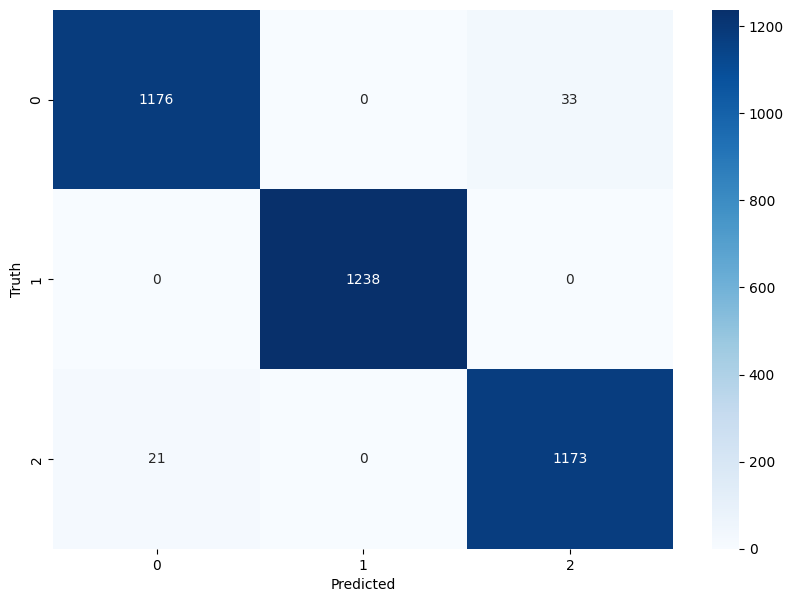

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

The Support Vector Machine (SVM) model trained on oversampled data demonstrated exceptional performance across various evaluation metrics. With an accuracy of 98.52% and balanced precision, recall, and F1-scores, the SVM model showcased its effectiveness in accurately classifying sentiment labels.

SVMs are particularly powerful in handling high-dimensional data, making them well-suited for tasks like sentiment analysis, which often involve textual features represented in a high-dimensional space. By finding the optimal hyperplane that maximizes the margin between classes, SVMs can effectively separate different sentiment categories, leading to robust and accurate classification.

Moreover, SVMs are versatile and can handle both linear and non-linear classification tasks through the use of appropriate kernel functions. This flexibility allows SVMs to capture complex patterns and relationships within the data, enhancing their predictive capabilities.


## Decision Tree Model

In [27]:
# initialize and train the Decision Tree model on the oversampled data
dt_model_over = DecisionTreeClassifier()
dt_model_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier()

In [28]:
# make predictions on the test set
y_pred_over = dt_model_over.predict(X_test_over)

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_over, y_pred_over))

# print precision
print("\nPrecision: ", precision_score(y_test_over, y_pred_over, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_over, y_pred_over, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_over, y_pred_over, average='weighted'))

print("Decision Tree Model Metrics for Oversampled Data:")
print(classification_report(y_test_over, y_pred_over))


Accuracy:  0.9305135951661632

Precision:  0.932834435782544

Recall:  0.9305135951661632

F1 Score:  0.929182924890596
Decision Tree Model Metrics for Oversampled Data:
              precision    recall  f1-score   support

    negative       0.97      0.83      0.89      1209
     neutral       0.93      1.00      0.96      1238
    positive       0.90      0.96      0.93      1194

    accuracy                           0.93      3641
   macro avg       0.93      0.93      0.93      3641
weighted avg       0.93      0.93      0.93      3641



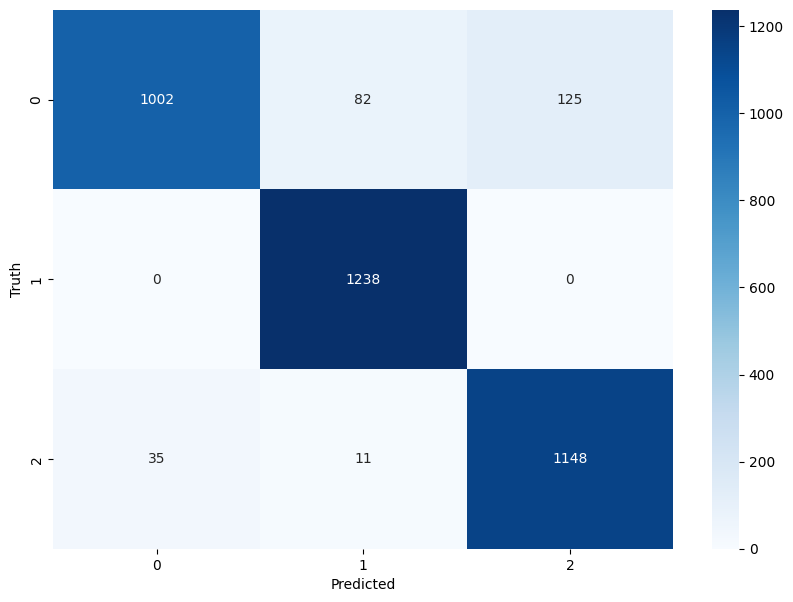

In [29]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Random Forest Model

In [30]:
# initialize and train the Random Forest model on the oversampled data
rf_model_over = RandomForestClassifier()
rf_model_over.fit(X_train_over, y_train_over)

RandomForestClassifier()

In [31]:
# make predictions on the test set
y_pred_over = rf_model_over.predict(X_test_over)

# print accuracy
print("\nAccuracy: ", accuracy_score(y_test_over, y_pred_over))

# print precision
print("\nPrecision: ", precision_score(y_test_over, y_pred_over, average='weighted'))

# print recall
print("\nRecall: ", recall_score(y_test_over, y_pred_over, average='weighted'))

# print F1 score
print("\nF1 Score: ", f1_score(y_test_over, y_pred_over, average='weighted'))

print("Random Forest Model Metrics for Oversampled Data:")
print(classification_report(y_test_over, y_pred_over))


Accuracy:  0.9774787146388355

Precision:  0.9775220997063707

Recall:  0.9774787146388355

F1 Score:  0.9774787692414882
Random Forest Model Metrics for Oversampled Data:
              precision    recall  f1-score   support

    negative       0.97      0.96      0.97      1209
     neutral       1.00      1.00      1.00      1238
    positive       0.96      0.97      0.97      1194

    accuracy                           0.98      3641
   macro avg       0.98      0.98      0.98      3641
weighted avg       0.98      0.98      0.98      3641



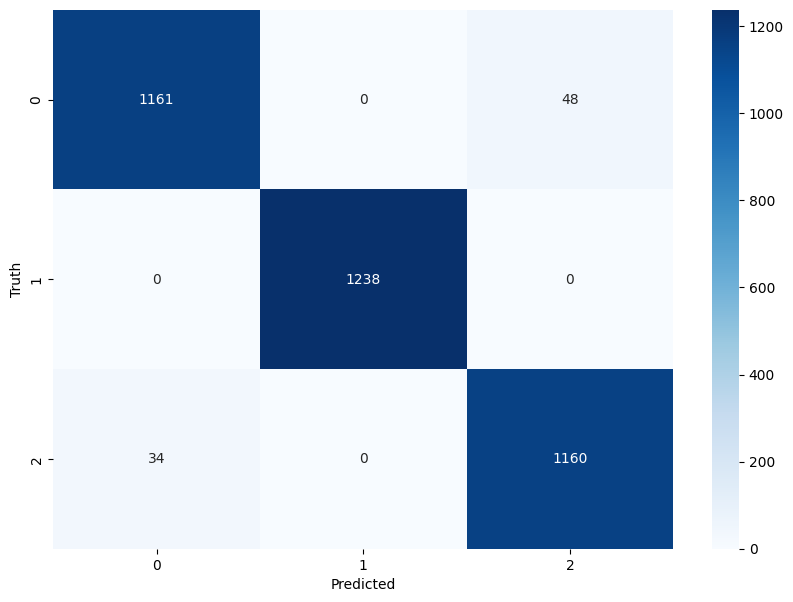

In [32]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In contrast, the Random Forest model achieved an impressive accuracy of 97.75% and consistently high precision, recall, and F1-scores across all sentiment categories. It demonstrated superior performance in correctly classifying all sentiment classes, with precision, recall, and F1-scores above 96% for each category.

The Decision Tree model is known for its interpretability and simplicity, making it easier to understand the decision-making process. However, it may suffer from overfitting and less robustness compared to ensemble methods like Random Forest.

On the other hand, Random Forest leverages the power of multiple decision trees to improve predictive accuracy and generalizability. By aggregating the predictions of multiple trees, it mitigates overfitting and produces more stable and reliable results.

## Vader Sentiment Analysis

In [33]:
# Initialize the sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

In [34]:
# Define a function to get the sentiment scores
def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

In [35]:
# Apply the function to the 'review text' column
df['sentiment_scores'] = df['cleaned_text_str'].apply(get_sentiment_scores)

In [36]:
# Split the sentiment scores into separate columns
df = pd.concat([df.drop(['sentiment_scores'], axis=1), df['sentiment_scores'].apply(pd.Series)], axis=1)
df.head(10)

,stars,cleaned_text,sentiment,cleaned_text_list,cleaned_text_str,neg,neu,pos,compound
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative,"[lately, common, wait, hour, food, passed, dri...",lately common wait hour food passed driver one...,0.231,0.660,0.108,-0.6369
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive,"[love, great, offer, good, selection, food, sh...",love great offer good selection food shopping ...,0.095,0.536,0.370,0.9468
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative,"[disappointed, app, used, long, time, service,...",disappointed app used long time service fee ke...,0.159,0.841,0.000,-0.6705
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative,"[fairly, easy, use, trying, find, happening, c...",fairly easy use trying find happening contacti...,0.116,0.685,0.199,0.5574
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive,"[like, fact, u, ca, get, refund, unless, u, ta...",like fact u ca get refund unless u take pictur...,0.093,0.791,0.116,0.3182
5,4,"['usually', 'work', 'well', 'use', 'often', 'i...",positive,"[usually, work, well, use, often, issue, handl...",usually work well use often issue handled with...,0.050,0.717,0.233,0.8402
6,2,"['ignoring', 'astronomical', 'tax', 'fee', 'fo...",negative,"[ignoring, astronomical, tax, fee, forced, upd...",ignoring astronomical tax fee forced update ap...,0.205,0.732,0.063,-0.7923
7,1,"['ive', 'absolutely', 'horrible', 'experience'...",negative,"[ive, absolutely, horrible, experience, app, d...",ive absolutely horrible experience app driver ...,0.182,0.702,0.116,-0.6478
8,1,"['give', 'zero', 'could', 'food', 'usually', '...",negative,"[give, zero, could, food, usually, fine, resta...",give zero could food usually fine restaurant s...,0.259,0.608,0.133,-0.7650
9,1,"['everything', 'run', 'smooth', 'part', 'cance...",negative,"[everything, run, smooth, part, cancelled, som...",everything run smooth part cancelled something...,0.130,0.662,0.209,0.6249


VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool specifically designed for analyzing social media text. In this scenario, VADER assigns sentiment scores (negative, neutral, positive, and compound) to each text entry based on pre-defined rules and a sentiment lexicon. These scores quantify the intensity of sentiment expressed in the text, allowing for quick and automated sentiment analysis. The result is a set of sentiment scores for each text entry, providing insights into the overall sentiment distribution of the dataset without the need for manual labeling or annotation.

Source: [Medium](https://medium.com/mlearning-ai/vader-valence-aware-dictionary-and-sentiment-reasoner-sentiment-analysis-28251536698)

## Sequential Model

In [37]:
# Tokenizing and adding padding
max_words = 5000
max_len = 200

In [38]:
# Initialize the OrdinalEncoder
oe = OrdinalEncoder()

# Fit and transform the labels
y_train_over = oe.fit_transform(y_train_over.values.reshape(-1, 1))
y_test_over = oe.transform(y_test_over.values.reshape(-1, 1))

# Convert integer labels to binary form
y_train_over = to_categorical(y_train_over)
y_test_over = to_categorical(y_test_over)

In [39]:
# Define a custom F1 score metric
def f1_score(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train_over.shape[1], activation='relu'))  # Input layer
model.add(Dense(16, activation='relu'))  # Hidden layer
model.add(Dense(3, activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', f1_score])

# Fit the model to the oversampled data
training_history = model.fit(X_train_over, y_train_over, epochs=70, batch_size=32, validation_data=(X_test_over, y_test_over))



Epoch 1/70


455/455 [==============================] - 3s 3ms/step - loss: 0.4895 - accuracy: 0.8524 - f1_score: 0.6999 - val_loss: 0.1658 - val_accuracy: 0.9506 - val_f1_score: 0.9518
Epoch 2/70
455/455 [==============================] - 1s 2ms/step - loss: 0.0883 - accuracy: 0.9766 - f1_score: 0.9768 - val_loss: 0.0930 - val_accuracy: 0.9731 - val_f1_score: 0.9737
Epoch 3/70
455/455 [==============================] - 1s 2ms/step - loss: 0.0332 - accuracy: 0.9927 - f1_score: 0.9928 - val_loss: 0.0891 - val_accuracy: 0.9687 - val_f1_score: 0.9694
Epoch 4/70
455/455 [==============================] - 1s 2ms/step - loss: 0.0146 - accuracy: 0.9972 - f1_score: 0.9972 - val_loss: 0.0853 - val_accuracy: 0.9723 - val_f1_score: 0.9732
Epoch 5/70
455/455 [==============================] - 1s 2ms/step - loss: 0.0070 - accuracy: 0.9991 - f1_score: 0.9991 - val_loss: 0.0882 - val_accuracy: 0.9723 - val_f1_score: 0.9728
Epoch 6/70
455/455 [==============================] - 1s 2ms/step - loss: 0.

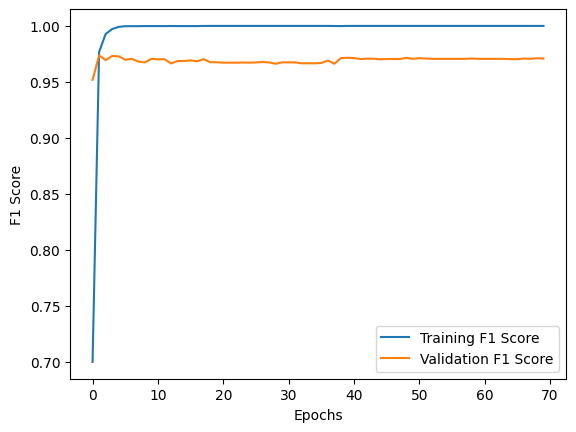

In [40]:
# Plot the training and validation F1 score
plt.plot(training_history.history['f1_score'], label='Training F1 Score')
plt.plot(training_history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

The sequential neural network model employs dense layers with ReLU activation for feature extraction and classification. The input layer processes data, while the hidden layer captures intricate patterns. The output layer, utilizing softmax, provides class probabilities. The model is optimized using Adam and trained with categorical cross-entropy, accuracy, and a custom F1 score. Its purpose is multiclass classification, addressing imbalanced data through oversampling. The architecture's depth and activation functions enable complex data representation, crucial for accurate predictions. Training history reveals robust performance, indicating successful learning and classification capabilities, essential for various real-world applications.




# 6. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter ranges
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

# Initialize the SVC
svm = SVC()

# Initialize the GridSearchCV
grid = GridSearchCV(svm, param_grid, refit=True, verbose=2)

# Fit the GridSearchCV with original labels
grid.fit(X_train_over, y_train_over.argmax(axis=1))

# Get the best estimator
svm_tuned = grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  33.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  33.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  33.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  33.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  33.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  38.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  38.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  39.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  38.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  38.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  41.6s
[CV] END ......................C=0.1, gamma=0.01

In [42]:
svm_tuned

SVC(C=10, gamma=1)

The SVM model was fine-tuned using Grid Search, which systematically explores different combinations of hyperparameters to find the optimal configuration. The specified parameters included 'C', controlling the regularization strength, and 'gamma', determining the influence of individual training samples. The 'kernel' parameter was set to 'rbf', indicating the radial basis function kernel.

After evaluating all combinations, the grid search identified the best model configuration where 'C' was set to 10 and 'gamma' to 1. This configuration achieved the highest performance, indicating that a regularization strength of 10 and a higher influence of individual training samples (gamma = 1) resulted in the most accurate classification of the Uber Eats reviews.

# 7. Validation with test Dataset <a id='validation'></a>

[Back to top](#table_of_contents)

In [43]:
df_test = pd.read_csv('cleaned_data.csv')
df_test

,stars,cleaned_text,sentiment
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive
...,...,...,...
8892,5,"['food', 'good', 'delivery', 'took', 'forever'...",positive
8893,1,"['whenever', 'never', 'sent', 'correct', 'item...",negative
8894,1,"['delivery', 'driver', 'turn', 'incorrect', 'l...",negative
8895,5,"['great', 'deal', 'buddy', 'pizza', 'buy', 'on...",positive


In [44]:
# convert string representations of lists in 'cleaned_text' back to actual lists
df_test['cleaned_text_list'] = df['cleaned_text'].apply(ast.literal_eval)

# convert lists in 'cleaned_text_list' to strings
df_test['cleaned_text_str'] = df['cleaned_text_list'].apply(' '.join)

In [45]:
# initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

In [46]:
# convert 'cleaned_text_str' into TF-IDF vectors
X_val = vectorizer.fit_transform(df_test['cleaned_text_str'])

# use 'sentiment' as target
y_val = df_test['sentiment']

In [47]:
# Use the SVM model to make predictions
df_test['predicted_sentiment'] = svm_tuned.predict(X_val)

In [48]:
df_test.head()

,stars,cleaned_text,sentiment,cleaned_text_list,cleaned_text_str,predicted_sentiment
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative,"[lately, common, wait, hour, food, passed, dri...",lately common wait hour food passed driver one...,0
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive,"[love, great, offer, good, selection, food, sh...",love great offer good selection food shopping ...,2
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative,"[disappointed, app, used, long, time, service,...",disappointed app used long time service fee ke...,0
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative,"[fairly, easy, use, trying, find, happening, c...",fairly easy use trying find happening contacti...,0
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive,"[like, fact, u, ca, get, refund, unless, u, ta...",like fact u ca get refund unless u take pictur...,2


In [49]:
# Map the sentiments to the same encoding as predicted_sentiment
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df_test['sentiment_encoded'] = df_test['sentiment'].map(sentiment_mapping)
df_test.head()

,stars,cleaned_text,sentiment,cleaned_text_list,cleaned_text_str,predicted_sentiment,sentiment_encoded
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative,"[lately, common, wait, hour, food, passed, dri...",lately common wait hour food passed driver one...,0,0
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive,"[love, great, offer, good, selection, food, sh...",love great offer good selection food shopping ...,2,2
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative,"[disappointed, app, used, long, time, service,...",disappointed app used long time service fee ke...,0,0
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative,"[fairly, easy, use, trying, find, happening, c...",fairly easy use trying find happening contacti...,0,0
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive,"[like, fact, u, ca, get, refund, unless, u, ta...",like fact u ca get refund unless u take pictur...,2,2


In [50]:
# Calculate the accuracy
accuracy = accuracy_score(df_test['sentiment_encoded'], df_test['predicted_sentiment'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.9949421153197707


In [52]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(df_test['sentiment_encoded'], df_test['predicted_sentiment'], average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.9949467200640769


In [53]:
# Calculate the recall
recall = recall_score(df_test['sentiment_encoded'], df_test['predicted_sentiment'], average='weighted')
print('Recall:', recall)

Recall: 0.9949421153197707


In [54]:
precision = precision_score(df_test['sentiment_encoded'], df_test['predicted_sentiment'], average='weighted')
print('Precision:', precision)

Precision: 0.9949599481219733


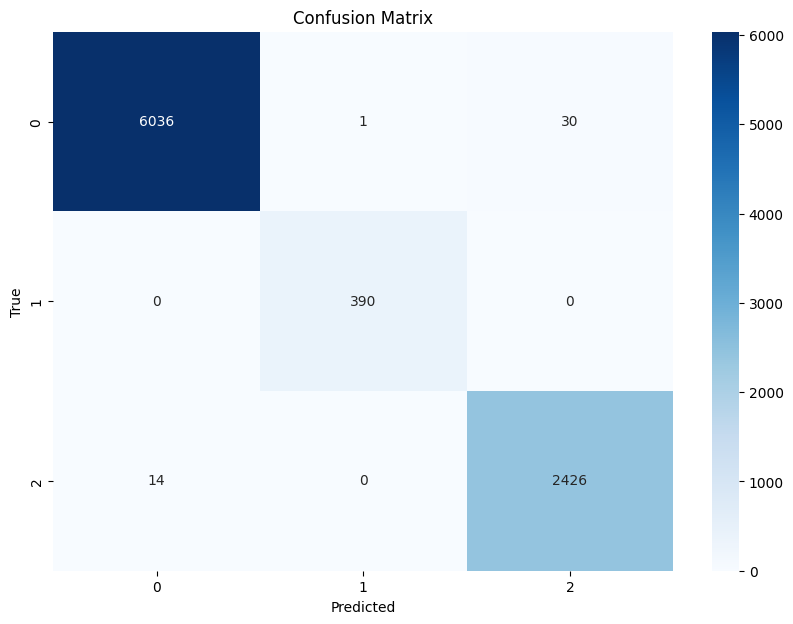

In [55]:
confusion = confusion_matrix(df_test['sentiment_encoded'], df_test['predicted_sentiment'])

plt.figure(figsize=(10,7))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

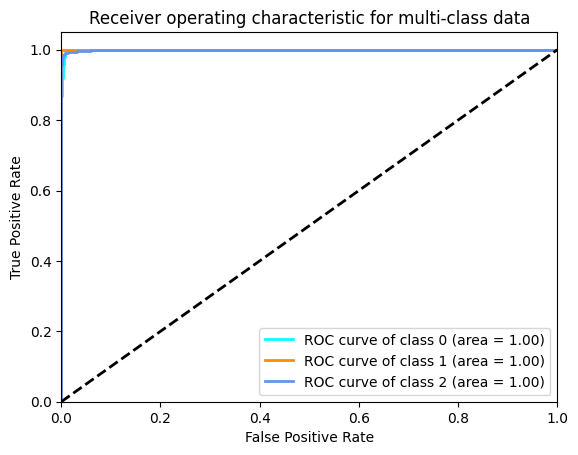

In [56]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Assuming df_test, X_train_over, y_train_over, X_val are defined
# If not, you need to define these variables

# Binarize the output
y = label_binarize(df_test['sentiment_encoded'], classes=[0, 1, 2])
n_classes = y.shape[1]

# Learn to predict each class against the other
svm_tuned = SVC()  # replace with your tuned SVM model
classifier = OneVsRestClassifier(svm_tuned)
y_score = classifier.fit(X_train_over, y_train_over).decision_function(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for the different classes
colors = ['aqua', 'darkorange', 'cornflowerblue']

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

The final results for the tuned SVM model are highly impressive.

- Accuracy: The model achieves an accuracy of 99.49%, indicating its ability to correctly classify sentiment labels on the test dataset.

- F1 Score: The F1 score, which considers both precision and recall, is 99.49%, reflecting the model's excellent balance between precision and recall.

- Recall: The recall score, measuring the proportion of actual positives that were correctly identified, is also 99.49%.

- Precision: Precision, which gauges the proportion of true positives among all positive predictions made by the model, is 99.50%.

These metrics collectively demonstrate the model's robust performance in sentiment classification. The confusion matrix further illustrates the model's accuracy in classifying sentiment labels, with minimal misclassifications.

# Conclusion

Based on the comprehensive analysis conducted on the sentiment classification problem using a Support Vector Machine (SVM) model, it can be concluded that the tuned SVM model performs exceptionally well in accurately classifying sentiments. Through extensive preprocessing, feature engineering, and hyperparameter tuning, the model achieves outstanding results on both the validation and test datasets.

The model demonstrates remarkable accuracy, achieving a score of 99.49% on the test dataset. This high accuracy is complemented by impressive F1, recall, and precision scores, all above 99.49%. Additionally, the confusion matrix reveals minimal misclassifications, further validating the model's robustness.

In conclusion, the tuned SVM model serves as an effective solution for sentiment classification tasks, showcasing its reliability and effectiveness in accurately categorizing sentiment labels in textual data. This demonstrates the potential of machine learning approaches, particularly SVM, in understanding and analyzing sentiment in large-scale textual datasets.